# Tutorial: creación de ETLs con PySpark

## 1. Introducción	
    ¿Qué aprenderá?
	En este tutorial aprenderá cómo puede utilizar PySpark para crear un proceso de ETL básico.

	¿Qué construirá?     
        Construirá un ETL que toma los datos desde la base de datos transacional de WideWorldImporters (WWImportersTransactional), los transforma  a una representación cercana al análisis y los  almacena en la base de datos relacional WWImportersDWH.
    
	¿Para qué?
	La construcción de ETLs que se ajusten a modelos multidimensionales es un paso necesario dentro de un proceso de analìtica 1.0 , pues permite tomar los datos crudos de una fuente, generalmente transaccional, para transformarlos en datos limpios que puedan utilizarse para la toma de decisiones.
    
    ¿Qué necesita?
    1. Python 3 con pip instalado
    2. Jupyter notebook
    3. Paquetes: Pyspark (3.0.1) y pandas (1.2.1)
    4. Controlador Connector J de MySQL (ya se encuentra instalado)
    5. Servidor SQL con base de datos relacional "WWImportersTransactional" y base de datos relacional que corresponde a la bodega de WWI "Estudiante_i"
	

## 2. Proceso de ETL para una dimensión.

En este proceso de ETL, se extraen los datos de las **órdenes de compra** de una base de datos transaccional y se almacenan en otra base de datos que corresponde a la bodega de datos, siguiendo una aproximación ROLAP. A continuación, se presenta el modelo multidimensional que es el modelo conceptual que representa el proceso de registro de órdenes de compra. Este modelo se utilizó para crear las tablas en la bodega de datos que representan el proceso de negocio y que serán cargadas como resultado del proceso ETL. 

Tenga en cuenta que las llaves ID_XXXX presentes en el modelo hacen referencia a las llaves de la bodega. Por otra parte, en el proceso de ETL se van a tener en cuenta las llaves transaccionales (**WWImportersTransactional**). La nomenclatura para utilizar es:

1.   ID_XXXX_DWH, para las llaves de la bodega.
2.   ID_XXXX_T, para las llaves transaccionales.


![Modelo ordenes](./WWI_modelo_ordenes.PNG)

El proceso de ETL debe ser diseñado antes de implementarse. A partir de las conclusiones del entendimiento de datos sabemos las fuentes que se van a  utilizar y la relación entre las fuentes. Adicionalmente, se cuenta con las respuestas de la organización a las preguntas, resultado del entendimiento de datos. De esa manera sabemos cómo se deben manipular los datos. 

Este proceso de ETL lo dividimos en seis bloques, uno para cada dimensión o <i>tabla de hechos</i> del modelo, con la única excepción de la dimensión de fecha que, por ser una dimensión especial que se genera de forma independiente, no se incluye aquí:

![ETL](./Disenio_ETL.PNG)

Recuerde que este es el diseño general. En el diseño completo se deben incluir las transformaciones realizadas a los datos a utilizarse en las dimensiones y tablas de hecho del modelo multidimensional, de acuerdo con lo que se muestra en la infografía de arquitectura de componentes (Componente proceso ETL) 

In [1]:
# Configuración servidor base de datos transaccional
# Recuerde usar Estudiante_i como usuario y la contraseña asigana en el excel de conexión a maquina virtual como contraseña
db_user = 'Estudiante_8_202215'
db_psswd = 'AaBb1122'
source_db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'

dest_db_connection_string = 'jdbc:mysql://157.253.236.116:8080/Estudiante_8_202215'
#dest_db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ETL_Test'

# Driver de conexion
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [2]:
import os 
from pyspark.sql import functions as f, SparkSession, types as t
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import udf, col, length, isnan, when, count, regexp_replace
from datetime import datetime

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


### Conexión y carga de datos

Se define la función para conexión y cargue de dataframes desde la base de datos origen y luego la función para guardar un dataframe en una tabla de la base de datos destino.

In [4]:
def obterner_dataframe_desde_csv(_PATH, _sep):
    return spark.read.load(_PATH, format="csv", sep=_sep, inferSchema="true", header='true')

def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

def guardar_db(db_connection_string, df, tabla, db_user, db_psswd):
    df.select('*').write.format('jdbc') \
      .mode('append') \
      .option('url', db_connection_string) \
      .option('dbtable', tabla) \
      .option('user', db_user) \
      .option('password', db_psswd) \
      .option('driver', 'com.mysql.cj.jdbc.Driver') \
      .save()

### BLOQUE 1
Empezamos con el bloque 1: la dimensión <i>Empleado</i>, su fuente de datos viene de la tabla transaccional <i>Personas</i>. En la sentencia SQL filtramos usando WHERE para seleccionar solo las personas que sean vendedores y recuperamos únicamente los atributos que queremos, de acuerdo con  modelo dimensional. Recuerde que también puede usar el **.select()** de pyspark si no conoce los atributos de las tablas transaccionales. Sin embargo, es más eficiente aplicar el filtro en la consulta, ya que no trae a memoria más información de la necesaria.

#### Extracción
A continuación, nos conectamos a la base de datos y extraemos la información deseada por medio de SQL, cargandola en un DataFrame PySpark, es decir en memoria. Note que aquí se pueden renombrar los atributos con la estructura <i>nombreActual AS nuevoNombre</i>. De la tabla de personas, En este paso, solo nos interesan los empleados, por lo cual se hace un filtro por medio del WHERE, buscando las personas cuyo atributo EsVendedor sea igual a 1.

In [5]:
sql_empleados = '''(SELECT DISTINCT ID_persona AS ID_Empleado, NombreCompleto AS Nombre, EsVendedor FROM WWImportersTransactional.Personas WHERE EsVendedor=1) AS Temp_empleados'''
empleados = obtener_dataframe_de_bd(source_db_connection_string, sql_empleados, db_user, db_psswd)
empleados.show(10)



+-----------+------------------+----------+
|ID_Empleado|            Nombre|EsVendedor|
+-----------+------------------+----------+
|          2|    Kayla Woodcock|      true|
|          3|     Hudson Onslow|      true|
|          6|     Sophia Hinton|      true|
|          7|         Amy Trefl|      true|
|          8|    Anthony Grosse|      true|
|         13|Hudson Hollinworth|      true|
|         14|         Lily Code|      true|
|         15|         Taj Shand|      true|
|         16|     Archer Lamble|      true|
|         20|       Jack Potter|      true|
+-----------+------------------+----------+



#### Transformación
Recuerde que, puede hacer uso de selectExpr, filter, where entre otras de PySpark para modificar los datos cargados. Por ejemplo, el siguiente código utiliza <i>selectExpr</i> para renombrar la columna ID_Empleado por ID_Empleado_T, esta es la convención que vamos a utilizar: "_T" para indicar que el ID es el que estaba en la base de datos transaccional y "_DWH" para indicar que son ID's propios de la bodega. Usamos withColumn y monotonicallu_increasing_id para crear un ID acumulativo para cada registro en el dataframe

In [6]:
# TRANSFORMACION
empleados = empleados.selectExpr('ID_Empleado as ID_Empleado_T','Nombre')
empleados = empleados.coalesce(1).withColumn('ID_Empleado_DWH', f.monotonically_increasing_id() + 1)
empleados = empleados.select('ID_Empleado_DWH','ID_Empleado_T','Nombre')
empleados.show(5)

+---------------+-------------+--------------+
|ID_Empleado_DWH|ID_Empleado_T|        Nombre|
+---------------+-------------+--------------+
|              1|            2|Kayla Woodcock|
|              2|            3| Hudson Onslow|
|              3|            6| Sophia Hinton|
|              4|            7|     Amy Trefl|
|              5|            8|Anthony Grosse|
+---------------+-------------+--------------+
only showing top 5 rows



#### Carga
Una vez realizado esto, se guardan los resultados en la base de datos destino

In [ ]:
# CARGUE
guardar_db(dest_db_connection_string, empleados,'Estudiante_8_202215.Empleados', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 2
Empezamos el bloque 2: dimensión ciudad. Su fuente de datos es una combinación de las tablas transaccionales <i>paises, provinciasEstados y ciudades</i>

#### Extracción

In [7]:
#EXTRACCION
sql_paises = '''(SELECT DISTINCT ID_Pais, Nombre, Continente, Region, Subregion FROM WWImportersTransactional.Paises) AS Temp_paises'''
sql_provincias_estados = '''(SELECT DISTINCT ID_EstadosProvincias AS ID_EstadoProvincia, NombreEstadoProvincia, TerritorioVentas, ID_Pais FROM WWImportersTransactional.EstadosProvincias) AS Temp_estados_provincias'''
sql_ciudades = '''(SELECT DISTINCT ID_ciudad as ID_ciudad_T, NombreCiudad, ID_EstadoProvincia, Poblacion FROM WWImportersTransactional.Ciudades) AS Temp_ciudades'''

paises = obtener_dataframe_de_bd(source_db_connection_string, sql_paises, db_user, db_psswd)
provincias_estados = obtener_dataframe_de_bd(source_db_connection_string, sql_provincias_estados, db_user, db_psswd)
ciudades = obtener_dataframe_de_bd(source_db_connection_string, sql_ciudades, db_user, db_psswd)

print(ciudades.columns, paises.columns, provincias_estados.columns)

['ID_ciudad_T', 'NombreCiudad', 'ID_EstadoProvincia', 'Poblacion'] ['ID_Pais', 'Nombre', 'Continente', 'Region', 'Subregion'] ['ID_EstadoProvincia', 'NombreEstadoProvincia', 'TerritorioVentas', 'ID_Pais']


#### Transformación

In [8]:
# TRANSFORMACION
ciudades = ciudades.join(provincias_estados, how = 'left', on = 'ID_EstadoProvincia')
ciudades = ciudades.join(paises, how = 'left', on = 'ID_Pais')
ciudades = ciudades.coalesce(1).withColumn('ID_Ciudad_DWH', f.monotonically_increasing_id() + 1)
ciudades = ciudades.select('ID_Ciudad_DWH','ID_ciudad_T','NombreCiudad','Continente','Nombre','Poblacion',
                          'Region','TerritorioVentas','NombreEstadoProvincia','Subregion') \
                    .withColumnRenamed('Nombre','Pais')
ciudades.show(5)

+-------------+-----------+------------+-------------+-------------+---------+--------+----------------+---------------------+----------------+
|ID_Ciudad_DWH|ID_ciudad_T|NombreCiudad|   Continente|         Pais|Poblacion|  Region|TerritorioVentas|NombreEstadoProvincia|       Subregion|
+-------------+-----------+------------+-------------+-------------+---------+--------+----------------+---------------------+----------------+
|            1|         49|     Absecon|North America|United States|     8411|Americas|         Mideast|           New Jersey|Northern America|
|            2|        150|    Adelphia|North America|United States|     null|Americas|         Mideast|           New Jersey|Northern America|
|            3|        336|      Albion|North America|United States|     null|Americas|         Mideast|           New Jersey|Northern America|
|            4|        458|   Allamuchy|North America|United States|       78|Americas|         Mideast|           New Jersey|Northern A

#### Carga

In [ ]:
# CARGUE
guardar_db(dest_db_connection_string, ciudades,'Estudiante_8_202215.Ciudad', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 3
Bloque 3: dimensión paquete. Su fuente de datos es la tabla transaccional <i>Paquetes</i>

#### Extracción

In [9]:
#EXTRACCION
sql_paquetes = '''(SELECT DISTINCT ID_TipoPaquete AS ID_TipoPaquete_T, TipoPaquete AS Nombre FROM WWImportersTransactional.Paquetes) AS Temp_Paquetes'''
paquetes = obtener_dataframe_de_bd(source_db_connection_string, sql_paquetes, db_user, db_psswd)

#### Transformación

In [10]:
# TRANSFORMACION
paquetes = paquetes.coalesce(1).withColumn('ID_TipoPaquete_DWH', f.monotonically_increasing_id() + 1)
paquetes = paquetes.select('ID_TipoPaquete_DWH','ID_TipoPaquete_T','Nombre')
paquetes.show(5)

+------------------+----------------+------+
|ID_TipoPaquete_DWH|ID_TipoPaquete_T|Nombre|
+------------------+----------------+------+
|                 1|               1|   Bag|
|                 2|               2| Block|
|                 3|               3|Bottle|
|                 4|               4|   Box|
|                 5|               5|   Can|
+------------------+----------------+------+
only showing top 5 rows



#### Carga

In [ ]:
# CARGUE
guardar_db(dest_db_connection_string, paquetes,'Estudiante_8_202215.TipoPaquete', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 4
Bloque 4: dimensión producto, su fuente de datos es la combinación entre las tablas transaccionales Productos y Colores

#### Extracción

In [11]:
sql_productos = '''(SELECT DISTINCT ID_Producto as ID_Producto_T, ID_Color, NombreProducto, Marca, Necesita_refrigeracion, Dias_tiempo_entrega, Impuesto, PrecioUnitario, PrecioRecomendado FROM WWImportersTransactional.Producto) AS Temp_productos'''
sql_colores = '''(SELECT DISTINCT ID_Color, Color FROM WWImportersTransactional.Colores) AS Temp_colores'''

productos = obtener_dataframe_de_bd(source_db_connection_string, sql_productos, db_user, db_psswd)
colores = obtener_dataframe_de_bd(source_db_connection_string, sql_colores, db_user, db_psswd)

#### Transformación

In [12]:
# TRANSFORMACION
productos = productos.join(colores, how = 'left', on = 'ID_Color').fillna({'Color': 'Missing'})
productos = productos.coalesce(1).withColumn('ID_Producto_DWH', f.monotonically_increasing_id() + 1)
productos = productos.select('ID_Producto_DWH','ID_Producto_T','NombreProducto','Marca','Color','Necesita_refrigeracion','Dias_tiempo_entrega','PrecioRecomendado','Impuesto','PrecioUnitario')
productos.show(5)

+---------------+-------------+--------------------+-----+-------+----------------------+-------------------+-----------------+--------+--------------+
|ID_Producto_DWH|ID_Producto_T|      NombreProducto|Marca|  Color|Necesita_refrigeracion|Dias_tiempo_entrega|PrecioRecomendado|Impuesto|PrecioUnitario|
+---------------+-------------+--------------------+-----+-------+----------------------+-------------------+-----------------+--------+--------------+
|              1|            1|USB missile launc...| null|Missing|                     0|                 14|               37|      15|            25|
|              2|            4|USB food flash dr...| null|Missing|                     0|                 14|               48|      15|            32|
|              3|            5|USB food flash dr...| null|Missing|                     0|                 14|               48|      15|            32|
|              4|            6|USB food flash dr...| null|Missing|                     0

#### Carga

In [67]:
# CARGUE
guardar_db(dest_db_connection_string, productos,'Estudiante_8_202215.Producto', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 5
Bloque 5: dimensión cliente. Su fuente de datos es la combinación entre las tablas transaccionales Categorias de cliente, Grupos de compra y Clientes

#### Extracción

In [13]:
sql_categoriasCliente = '''(SELECT DISTINCT ID_Categoria, NombreCategoria FROM WWImportersTransactional.CategoriasCliente) AS Temp_categoriasclientes'''
sql_gruposCompra = '''(SELECT DISTINCT ID_GrupoCompra, NombreGrupoCompra FROM WWImportersTransactional.GruposCompra) AS Temp_gruposcompra'''
sql_clientes = '''(SELECT DISTINCT ID_Cliente as ID_Cliente_T, Nombre, ClienteFactura, ID_Categoria, ID_GrupoCompra, ID_CiudadEntrega, LimiteCredito, FechaAperturaCuenta, DiasPago FROM WWImportersTransactional.Clientes) AS Temp_clientes'''

categoriasCliente = obtener_dataframe_de_bd(source_db_connection_string, sql_categoriasCliente, db_user, db_psswd)
gruposCompra = obtener_dataframe_de_bd(source_db_connection_string, sql_gruposCompra, db_user, db_psswd)
clientes = obtener_dataframe_de_bd(source_db_connection_string, sql_clientes, db_user, db_psswd)

#### Transformación

In [14]:
# TRANSFORMACION 
# EL SUPUESTO QUE SE TIENE ES QUE TODOS LOS CLIENTES TIENEN TODOS SUS DATOS DE CATEGORIA Y GRUPO Y NO SE ESTÁN PERDIENDO CLIENTES AL REALIZAR ESTE JOIN
clientes = clientes.join(gruposCompra, how = 'left', on = 'ID_GrupoCompra')
clientes = clientes.alias('cl').join(categoriasCliente.alias('ct'), how = 'left', on = 'ID_Categoria') \
.select([col('cl.ID_Cliente_T'),col('cl.Nombre'),col('ct.NombreCategoria'),col('cl.NombreGrupoCompra') \
        ,col('cl.ClienteFactura'),col('cl.ID_CiudadEntrega'),col('cl.LimiteCredito'),col('cl.FechaAperturaCuenta'),col('cl.DiasPago')])
clientes = clientes.coalesce(1).withColumn('ID_Cliente_DWH', f.monotonically_increasing_id() + 1)
clientes = clientes.select('ID_Cliente_DWH','ID_Cliente_T','Nombre','NombreCategoria','NombreGrupoCompra','ClienteFactura',
                          'ID_CiudadEntrega','LimiteCredito','FechaAperturaCuenta','DiasPago')

clientes = clientes.fillna({'NombreCategoria':'Missing','NombreGrupoCompra':'Missing'})
clientes.show(5)

+--------------+------------+-----------------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|ID_Cliente_DWH|ID_Cliente_T|           Nombre|NombreCategoria|NombreGrupoCompra|ClienteFactura|ID_CiudadEntrega|LimiteCredito|FechaAperturaCuenta|DiasPago|
+--------------+------------+-----------------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|             1|         803|       Bala Dixit|   Novelty Shop|          Missing|           803|           33799|         2000|2013-01-01 00:00:00|       7|
|             2|         805|     Ratan Poddar|   Novelty Shop|          Missing|           805|           10194|         3300|2013-01-01 00:00:00|       7|
|             3|         806|           Shi Tu|   Novelty Shop|          Missing|           806|           31685|         3000|2013-01-01 00:00:00|       7|
|             4|         811|    Surendra Sahu|   Novelty 

In [15]:
# Crea el registro para el id = 0
clientes_0 = [('0','','Missing','Missing','Missing','0','0','','','')]
columns = ['ID_Cliente_DWH','ID_Cliente_T','Nombre','NombreCategoria','NombreGrupoCompra','ClienteFactura',
            'ID_CiudadEntrega','LimiteCredito','FechaAperturaCuenta','DiasPago']
cliente_0 = spark.createDataFrame(data=clientes_0,schema=columns)
cliente_0.show()

+--------------+------------+-------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|ID_Cliente_DWH|ID_Cliente_T| Nombre|NombreCategoria|NombreGrupoCompra|ClienteFactura|ID_CiudadEntrega|LimiteCredito|FechaAperturaCuenta|DiasPago|
+--------------+------------+-------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|             0|            |Missing|        Missing|          Missing|             0|               0|             |                   |        |
+--------------+------------+-------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+



In [16]:
clientes = clientes.union(cliente_0)
clientes.show(5)

+--------------+------------+------------------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|ID_Cliente_DWH|ID_Cliente_T|            Nombre|NombreCategoria|NombreGrupoCompra|ClienteFactura|ID_CiudadEntrega|LimiteCredito|FechaAperturaCuenta|DiasPago|
+--------------+------------+------------------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|             1|         807|     Gunnar Lohmus|     Gift Store|          Missing|           807|           35810|         3100|2013-01-01 00:00:00|       7|
|             2|         816|        Harsha Huq|     Gift Store|          Missing|           816|            8892|         2400|2013-01-01 00:00:00|       7|
|             3|         823|Francisca Laureano|     Gift Store|          Missing|           823|           17142|         3500|2013-01-01 00:00:00|       7|
|             4|         825|    Jayanta Thakur|    

In [17]:
# Se ordena por el identificador DWH
clientes = clientes.withColumn('ID_Cliente_DWH',col('ID_Cliente_DWH').cast('int')).orderBy(col('ID_Cliente_DWH'))
clientes.show(5)

+--------------+------------+------------------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|ID_Cliente_DWH|ID_Cliente_T|            Nombre|NombreCategoria|NombreGrupoCompra|ClienteFactura|ID_CiudadEntrega|LimiteCredito|FechaAperturaCuenta|DiasPago|
+--------------+------------+------------------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|             0|            |           Missing|        Missing|          Missing|             0|               0|             |                   |        |
|             1|         807|     Gunnar Lohmus|     Gift Store|          Missing|           807|           35810|         3100|2013-01-01 00:00:00|       7|
|             2|         816|        Harsha Huq|     Gift Store|          Missing|           816|            8892|         2400|2013-01-01 00:00:00|       7|
|             3|         823|Francisca Laureano|    

#### Carga

In [68]:
# CARGUE
guardar_db(dest_db_connection_string,clientes,'Estudiante_8_202215.Cliente', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

### BLOQUE 6
Bloque 6: Hecho orden. Su fuente de datos es la combinación entre las tablas transaccionales Ordenes y detalles de orden

#### Extracción

In [ ]:
sql_ordenes = '''(SELECT DISTINCT * FROM WWImportersTransactional.Ordenes) AS Temp_ordenes'''
sql_detallesOrdenes = '''(SELECT DISTINCT * FROM WWImportersTransactional.DetallesOrdenes) AS Temp_detallesordenes'''
ordenes = obtener_dataframe_de_bd(source_db_connection_string, sql_ordenes, db_user, db_psswd)
detallesOrdenes = obtener_dataframe_de_bd(source_db_connection_string, sql_detallesOrdenes, db_user, db_psswd)

#### Transformación
Estas son las respuestas de Wide World Importers a los conclusiones obtenidas en el entendimiento de los datos:
- La regla de negocio "La tasa de impuesto es de 10% o 15%" es correcta, pero habian errores en la tabla original, que fueron corregidos. 
- Para la segunda regla de negocio: "Son 73.595 órdenes detalladas en 231.412 lineas de detalle de órdenes realizadas desde 2013", si faltaban datos, los cuales fueron completados, y nos dicen que en cuanto a consistencia ellos revisaron las tablas e hicieron correcciones, pero que los duplicados completos de ordenes los eliminemos
- "El formato de fechas manejado es YYYY-MM-DD HH:MM:SS si tienen hora, minutos y segundos. De lo contrario el formato es YYYY-MM-DD": En cuanto a formatos de fechas estan de acuerdo con que los estandarizemos y el formato sea el especificado en la regla
- Para las descripciones de productos que eran "a", se actualizaron a los valores reales. 
- Se pueden eliminar las columnas Comenarios, Instrucciones_de_entrega y comentarios_internos porque estan vacias. 
- A pesar de estar en un proceso de mejorar la calidad de los datos y mantener los nulos nos ayudaría a reflejar esa calidad, de la mano con el grupo de analitica de WWI se decide imputar por la media el valor extremo de la variable Cantidad
- Para las ordenes las columnas Seleccionado_por_ID_de_persona, ID_de_pedido_pendiente, Seleccion_completada_cuando, y para las columnas Seleccion_completada_cuando de la tabla detalles de ordenes, se decide mantener los valores vacíos, sin embargo para la variable Precio_unitario el negocio reviso y complemento los valores faltantes

Las tablas usadas en el tutorial de entendimiento de datos estaran disponibles para su revision con los siguientes nombres: OrdenesCopia y DetallesOrdenesCopia. 

Para este tutorial vamos a trabajar con unas tablas que dadas las conclusiones del tutorial de entendimiento, WWImporters revisó los datos originales, creo tablas y las llamo "Ordenes" y "DetallesOrdenes"

Se hace una verificación de los valores de la tasa de impuesto

In [ ]:
detallesOrdenes.select("Tasa_de_impuesto").distinct().show()

Se hace una verificación del rango de fechas disponible en los datos

In [ ]:
ordenes.agg({"Fecha_de_pedido": "min"}).show()

Se elimina columnas Comenarios, Instrucciones_de_entrega y comentarios_internos

In [ ]:
ordenes = ordenes.drop(*["Comentarios", "Instrucciones_de_entrega","comentarios_internos"])

Se eliminan duplicados totales de ordenes

In [ ]:
print((ordenes.count(),ordenes.distinct().count()))

In [ ]:
ordenes = ordenes.drop_duplicates()

In [ ]:
print((ordenes.count(),ordenes.distinct().count()))

Se hace verificación de consistencia

In [ ]:
#consistencia: revisar genially: definicion de consistencia
ids_ordenes = set([x.ID_de_pedido for x in ordenes.select('ID_de_pedido').collect()])
ids_detalles = set([x.ID_de_pedido for x in detallesOrdenes.select('ID_de_pedido').collect()])

len(ids_ordenes-ids_detalles), len(ids_detalles-ids_ordenes)

En el siguiente código para el manejo de fechas, pasamos del formato MM dd,YYYY al formato establecido en la regla de negocio<br>

In [ ]:
# TRANSFORMACION
regex = "([0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1]))"
cumplenFormato = ordenes.filter(ordenes["Fecha_de_pedido"].rlike(regex))
noCumplenFormato = ordenes.filter(~ordenes["Fecha_de_pedido"].rlike(regex))
print(noCumplenFormato.count(), cumplenFormato.count())
print(noCumplenFormato.show(5))
noCumplenFormato = noCumplenFormato.withColumn('Fecha_de_pedido', f.udf(lambda d: datetime.strptime(d, '%b %d,%Y').strftime('%Y-%m-%d'), t.StringType())(f.col('Fecha_de_pedido')))
ordenes = noCumplenFormato.union(cumplenFormato)
noCumplenFormato.count(), ordenes.count()

Descripciones


In [ ]:
detallesOrdenes.where(length(col("Descripcion")) <= 10).show()

Imputar valor maximo de cantidad

In [ ]:
detallesOrdenes.select('Cantidad').sort(col("Cantidad").desc()).collect()[1]

In [ ]:
detallesOrdenes = detallesOrdenes.replace( 10000000, 360, 'Cantidad')

In [ ]:
detallesOrdenes.select('Cantidad').sort(col("Cantidad").desc()).collect()[0]

In [ ]:
detallesOrdenes.show(5)

In [ ]:
ordenes.show(5)

Se unen los dos dataframes en un nuevo dataframe, se verifica que no haya duplicados y si los hay se eliminan. Se crea un nuevo dataframe que va a tener toda la información del hecho orden transformada y lista para continuar el proceso de cargue.

In [ ]:
ordenes_tmp =ordenes
ordenes_tmp = ordenes_tmp.join(detallesOrdenes, how = 'inner', on = 'ID_de_pedido')
ordenes_tmp = ordenes_tmp.withColumn('Valor_total',col('Precio_unitario')*col('Cantidad'))
ordenes_tmp = ordenes_tmp.withColumn('Impuestos',col('Valor_total')*col('Tasa_de_impuesto'))
ordenes_tmp = ordenes_tmp.selectExpr('ID_de_pedido as ID_de_pedido_T','ID_Producto','Fecha_de_pedido','ID_de_cliente','ID_de_vendedor','ID_Tipo_Paquete','Cantidad','Valor_total', 'Impuestos')

print((ordenes_tmp.count(),ordenes_tmp.distinct().count()))

ordenes_tmp = ordenes_tmp.drop_duplicates()
ordenes_tmp.show(5)

In [ ]:
guardar_db(dest_db_connection_string, ordenes_tmp,'Estudiante_i_2022XX.Hecho_Orden_Tmp', db_user, db_psswd)

Cree la tabla de Fecha según el material compartido y adicione el left join al crear la tabla de ordenes para que quede completa

In [ ]:
# El idPedido representa la dimensión degenerada Pedido
# Si hay campos nulos en ordenes_tmp al hacer join por el left outer join no se perderan y se utiliza como comodín un id=0 que debe existir en todas las dimensiones.
# Ese comodín representa el registro sin Dato.
# Debe adicionarle a todas las tablas el registro con identificador 0, como se muestra para la tabla de clientes
# Recuerde que falta incluir el join con la tabla de Fecha para que la tabla quede completa.

ordenes = ordenes_tmp.alias('o').join(clientes.alias('cl'), ordenes_tmp.ID_de_cliente == clientes.ID_Cliente_T,'left')\
                    .join(ciudades.alias('ciu'), clientes.ID_CiudadEntrega == ciudades.ID_ciudad_T,'left') \
                    .join(empleados.alias('e'), ordenes_tmp.ID_de_vendedor == empleados.ID_Empleado_T,'left') \
                    .join(paquetes.alias('p'), ordenes_tmp.ID_Tipo_Paquete == paquetes.ID_TipoPaquete_T,'left') \
                    .join(productos.alias('pr'), (ordenes_tmp.ID_Producto == productos.ID_Producto_T) ,'left') \
                    .select([col('o.ID_de_pedido_T'),col('cl.ID_Cliente_DWH'),col('ciu.ID_Ciudad_DWH'),
                             col('e.ID_Empleado_DWH'),col('pr.ID_Producto_DWH'),col('p.ID_TipoPaquete_DWH'),
                             col('o.Cantidad'),col('o.Valor_total'),col('o.Impuestos')]) \
                    .fillna({'ID_Cliente_DWH': 0, 'ID_Ciudad_DWH': 0, 'ID_Empleado_DWH': 0, 'ID_Producto_DWH': 0,
                             'ID_TipoPaquete_DWH': 0})
ordenes.show(5)

In [ ]:
ordenes = ordenes.select('ID_de_pedido_T','ID_Ciudad_DWH','ID_Cliente_DWH','ID_Empleado_DWH','ID_Producto_DWH',
                         'ID_TipoPaquete_DWH','Cantidad','Impuestos','Valor_total') \
                    .withColumnRenamed('Valor_total','Total')
ordenes.show(5)

#### Carga

In [ ]:
guardar_db(dest_db_connection_string, ordenes,'Estudiante_8_202215.Hecho_Orden', db_user, db_psswd)

Verifique los resultados usando MySQL Workbench

# Resultado de consultas
Corresponde a las consultas realizadas sobre las tablas, para mostrar el estado final de las tablas pobladas como resultado del proceso de ETL.

# 3. Tarea ETL
Espacio para desarrollar la tarea planteada



# Enunciado
Ahora que sabe cómo realizar un proceso ETL, dado el modelo multidimensional del proceso de negocio de movimientos de inventario realice las siguientes actividades:

Entregable 1 - Diseño del ETL: Diseñe el ETL para las dimensiones proveedor, tipoTransaccion, fecha y para la tabla de hechos. A nivel de la tabla de proveedores incluya la tabla categoriasProveedores donde encuentra información de las categorías. El diseño del ETL es un diagrama como lo encuentra en la infografía de proceso ETL y puede observar en la siguiente figura. En el entregable utilice la siguiente plantilla para presentar el diseño de ETL e incluya una descripción general que permita comprender detalles que pueden ser confusos.

Entregable 2 - Implementación del ETL: implementación del proceso ETL para las dimensiones Proveedor, TipoTransaccion y para la tabla de hechos. En el entregable incluya una descripción general que permita comprender el proceso de implementación del ETL.

Note que para este proceso de negocio, las dimensiones Producto, Cliente y Fecha son iguales a las del hecho Orden, este caso se conoce como dimensiones compartidas. Usted debe concentrarse en las dimensiones Proveedor, TipoTransaccion, Fecha y la tabla de hechos que no existen en la bodega de datos actualmente.

WWImporters le comparte el modelo multidimensional que ha decido utilizar. Este modelo representa los movimientos(transacciones) que se hacen sobre el inventario de WWImporters. En particular, se observa que se tiene información de los tipos de transacciones, realizadas por un proveedor, relacionado con un cliente y un producto específico en una fecha determinada. En el modelo se dejan explícitos los dos tipos de identificadores que se crean a nivel de la bodega. el propio de la Bodega, (con el sufijo DWH) y el que viene de la fuente (con el sufijo T).

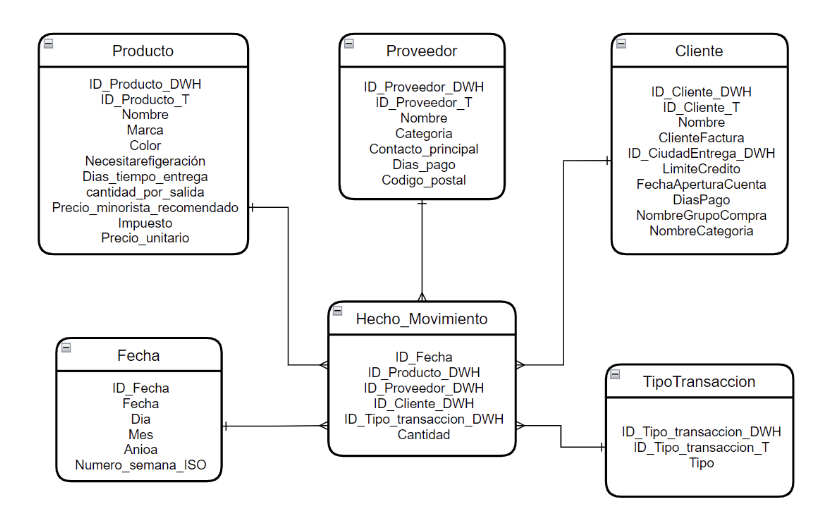

# BLOQUE 1
Bloque 1: Dimensión proveedor, su fuente de datos es la combinación entre las tablas transaccionales Proveedores ,  CategoriasProveedores y Personas
La dimensión Proveedor, su fuente de datos viene de la tabla transaccional proveedores. En la sentencia SQL se encuentra la combinación entre las tablas transaccionales CategoriasProveedores y Personas. Se extrae únicamente los atributos que queremos, de acuerdo con modelo dimensional. 

# Extracción
A continuación, extraemos la información deseada por medio de SQL de acuerdo al diseño de la dimension acorde al negocio, cargandola en un DataFrame PySpark. En la extracción, se realiza el renombre de los atributos de la tabla de proveedores de acuerdo con lo indicado en el modelo por el negoci; se realiza la modificación de las columnas NombreProveedor, CategoriaProveedor y NombreCompleto que se extraer de la base de datos proveedores compartida por el negocio. 


In [18]:
sql_proveedores ='''(SELECT ProveedorID ID_proveedor_T,
                        NombreProveedor Nombre  ,
                        CategoriaProveedor  categoria,
                        NombreCompleto Contacto_Principal ,
                        CASE
                        WHEN pv.DiasPago < 1 then -1 * pv.DiasPago
                         else DiasPago
                         end Dias_Pago,
                        pv.CodigoPostal Codigo_Postal
                        FROM proveedores pv left join CategoriasProveedores ct on ct.CategoriaProveedorID = pv.CategoriaProveedorID
                        left join Personas ps on  ps.ID_persona=pv.PersonaContactoPrincipalID
                        order by ProveedorID) AS Temp_proveedores'''
proveedores = obtener_dataframe_de_bd(source_db_connection_string, sql_proveedores, db_user, db_psswd)
proveedores.show(20)


+--------------+--------------------+--------------------+------------------+---------+-------------+
|ID_proveedor_T|              Nombre|           categoria|Contacto_Principal|Dias_Pago|Codigo_Postal|
+--------------+--------------------+--------------------+------------------+---------+-------------+
|             1| A Datum Corporation| productos novedosos|        Reio Kabin|       14|        46077|
|             2|       Contoso, Ltd.| productos novedosos|   Hanna Mihhailov|        7|        98253|
|             3|Consolidated Mess...|servicios de mens...|      Kerstin Parn|       30|        94101|
|             4|      Fabrikam, Inc.|                ropa|       Bill Lawson|       30|        40351|
|             5|Graphic Design In...| productos novedosos|        Penny Buck|       14|        64847|
|             6| Humongous Insurance|servicios de seguros|Madelaine  Cartier|       14|        37770|
|             7|       Litware, Inc.|            embalaje|     Elias Myllari|     

De acuerdo con el modelo se realiza la creacción del ID "_DWH" acumulativo para cada registro en el dataframe para indicar que son ID's propios de la bodega.

Durante la extracción en la columna DiasPago contenia datos negativos y de acuerdo al negocio se multiplica  los datos negativos por -1; se valida que la transformación se realiza de manera correcta.


In [19]:
proveedores.filter(proveedores.Dias_Pago <= 0 ).show()

+--------------+------+---------+------------------+---------+-------------+
|ID_proveedor_T|Nombre|categoria|Contacto_Principal|Dias_Pago|Codigo_Postal|
+--------------+------+---------+------------------+---------+-------------+
+--------------+------+---------+------------------+---------+-------------+



In [20]:
# TRANSFORMACION
proveedores = proveedores.coalesce(1).withColumn('ID_Proveedor_DWH', f.monotonically_increasing_id() + 1)
proveedores = proveedores.select('ID_Proveedor_DWH','ID_proveedor_T','Nombre','categoria','Contacto_Principal','Dias_Pago','Codigo_Postal')
proveedores.show(20)

+----------------+--------------+--------------------+--------------------+------------------+---------+-------------+
|ID_Proveedor_DWH|ID_proveedor_T|              Nombre|           categoria|Contacto_Principal|Dias_Pago|Codigo_Postal|
+----------------+--------------+--------------------+--------------------+------------------+---------+-------------+
|               1|             1| A Datum Corporation| productos novedosos|        Reio Kabin|       14|        46077|
|               2|             2|       Contoso, Ltd.| productos novedosos|   Hanna Mihhailov|        7|        98253|
|               3|             3|Consolidated Mess...|servicios de mens...|      Kerstin Parn|       30|        94101|
|               4|             4|      Fabrikam, Inc.|                ropa|       Bill Lawson|       30|        40351|
|               5|             5|Graphic Design In...| productos novedosos|        Penny Buck|       14|        64847|
|               6|             6| Humongous Insu

Una vez validada que la tabla(s) cumple con el modelo entregado se procede a realizar la carga en el ambiente de la consultoría para poder realizar la estructuración del Tablero de Control de acuerdo con el requerimiento de 
# "Visualizar la cantidad de productos vendidos y el valor  total recaudada en un rango de gechas por cliente, vendedor, ciudad y producto."

In [69]:
# CARGUE
guardar_db(dest_db_connection_string,proveedores,'Estudiante_8_202215.proveedor', db_user, db_psswd)

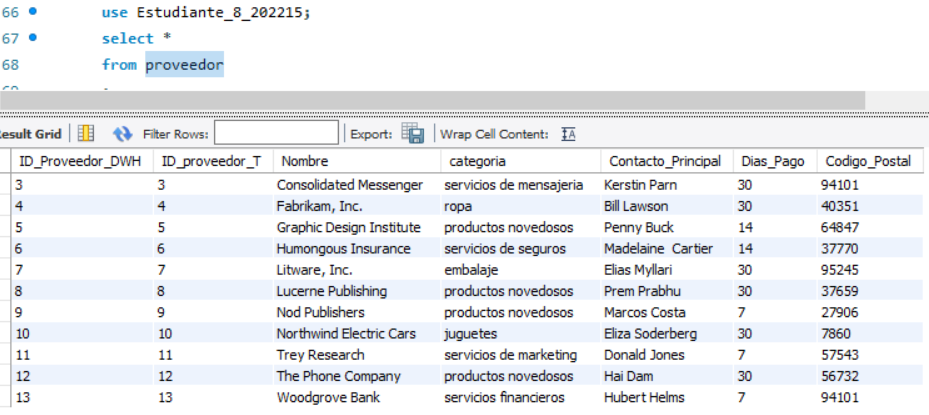

# BLOQUE 2
Bloque 2: dimensión tipotransacción, su fuente de datos es la tabla transaccionales TiposTransaccion
   
En la sentencia SQL se encuentra la combinación entre las tablas transaccionales TiposTransaccion. 
Se extrae únicamente para este caso el ID y  DEscripción del Tipo de Transacción, de acuerdo con modelo dimensional. 

# Extracción
Se extrae de la tabla compartida por el negocio TiposTransaccion la información de interes. En la extracción, se realiza el reenombre de los atributos de la tabla de TiposTransaccion.


In [21]:
sql_tpTransaccion ='''(SELECT TipoTransaccionID ID_Tipo_transaccion_T,
                            TipoTransaccionNombre Tipo
                        FROM TiposTransaccion
                        order by TipoTransaccionID) AS Temp_TiposTransaccion'''
tpTransaccion = obtener_dataframe_de_bd(source_db_connection_string, sql_tpTransaccion, db_user, db_psswd)
tpTransaccion.show(20)

+---------------------+--------------------+
|ID_Tipo_transaccion_T|                Tipo|
+---------------------+--------------------+
|                    2|Customer Credit Note|
|                    3|Customer Payment ...|
|                    4|     Customer Refund|
|                    5|    Supplier Invoice|
|                    6|Supplier Credit Note|
|                    7|Supplier Payment ...|
|                    8|     Supplier Refund|
|                    9|      Stock Transfer|
|                   10|         Stock Issue|
|                   11|       Stock Receipt|
|                   12|Stock Adjustment ...|
|                   13|     Customer Contra|
+---------------------+--------------------+



# Transformación

Se realiza la creación del ID propio de la tabla para lo cual se emplea en el nombre el "DWH" de acuerdo con lo indicado por el negocio.

In [22]:
tpTransaccion = tpTransaccion.coalesce(1).withColumn('ID_tpTransaccion_DWH', f.monotonically_increasing_id() + 1)
tpTransaccion = tpTransaccion.select('ID_tpTransaccion_DWH','ID_Tipo_transaccion_T','Tipo')
tpTransaccion.show(20)

+--------------------+---------------------+--------------------+
|ID_tpTransaccion_DWH|ID_Tipo_transaccion_T|                Tipo|
+--------------------+---------------------+--------------------+
|                   1|                    2|Customer Credit Note|
|                   2|                    3|Customer Payment ...|
|                   3|                    4|     Customer Refund|
|                   4|                    5|    Supplier Invoice|
|                   5|                    6|Supplier Credit Note|
|                   6|                    7|Supplier Payment ...|
|                   7|                    8|     Supplier Refund|
|                   8|                    9|      Stock Transfer|
|                   9|                   10|         Stock Issue|
|                  10|                   11|       Stock Receipt|
|                  11|                   12|Stock Adjustment ...|
|                  12|                   13|     Customer Contra|
+---------

In [70]:
# CARGUE
guardar_db(dest_db_connection_string,tpTransaccion,'Estudiante_8_202215.TipoTransaccion', db_user, db_psswd)

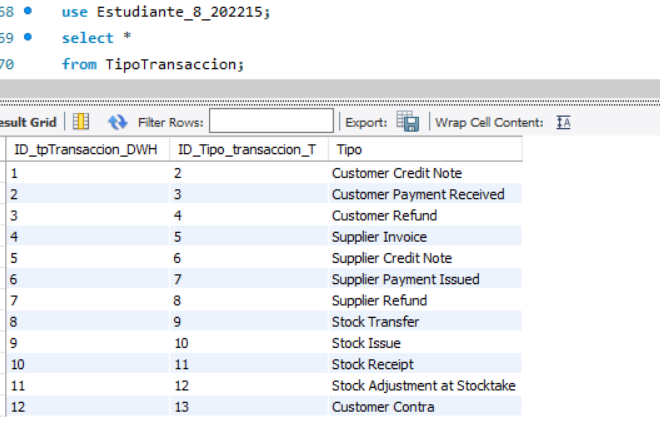

# BLOQUE 3
Bloque 3: dimensión fecha, su fuente de datos es la tabla transaccionales TiposTransaccion; de donde se extraerán las fechas para construir la Dimensión Fecha que se empleará en el modelo y en la estructuración del tablero de control.

# Extracción
A continuación, extraemos la información deseada por medio de SQL de la FechaTransaccion de la tabla movimiento; de interes para esta consultoría y que permitirá dar respuesta a los rangos requeridos en el Tablero de Control.

# Transformación
Se realiza el cargue de la información se validan los formatos que se tienen se extraen los datos para definir, día, mes y año de la FechaTransacción, posterior se incluye la columna de semana ISO; dando cumplimiento a los atributos requeridos para la tabla y las transformaciones.

In [23]:
sql = '''(SELECT DISTINCT FechaTransaccion AS Fecha FROM WWImportersTransactional.movimientos) AS Temp_fechas_movimientos'''
fecha = obtener_dataframe_de_bd(source_db_connection_string, sql, db_user, db_psswd)

# TRANSFORMACION 
#Convertir la fecha a un número que la representa en formato YYYYMMDD
#Convertir Fecha a Formato Datetime de acuerdo con la regla de negocio.

regex = "([0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1]))" # AAAAMMDD
cumplenFormato = fecha.filter(fecha["Fecha"].rlike(regex))
noCumplenFormato = fecha.filter(~fecha["Fecha"].rlike(regex))
print(noCumplenFormato.count(), cumplenFormato.count())

noCumplenFormato = noCumplenFormato.withColumn('ID_Fecha', f.udf(lambda d: int(datetime.strptime(d, '%b %d,%Y').strftime('%Y%m%d')), t.IntegerType())(f.col('Fecha')))
noCumplenFormato = noCumplenFormato.withColumn('Fecha', f.udf(lambda d: datetime.strptime(d, '%b %d,%Y').strftime('%Y-%m-%d'), t.StringType())(f.col('Fecha')))

cumplenFormato = cumplenFormato.withColumn('ID_Fecha', f.udf(lambda d: int(datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f0').strftime('%Y%m%d')), t.IntegerType())(f.col('Fecha')))

fecha = noCumplenFormato.union(cumplenFormato)

#Crear columnas día, mes y año de acuerdo con la fecha modificada a Datetime.

from pyspark.sql.functions import dayofmonth, to_date, month, year, weekofyear
fecha = fecha.withColumn('Dia',dayofmonth(fecha.Fecha))
fecha = fecha.withColumn('Mes',month(fecha.Fecha))
fecha = fecha.withColumn('Anioa',month(fecha.Fecha))

#Obtener semana del año de la fecha según códgo ISO.

fecha = fecha.withColumn('Numero_semana_ISO',weekofyear(fecha.Fecha))

# Al contar con varios formatos en las transformaciones es posible que persistan los duplicados por lo que se
#eliminana para contar con fechas duplicados y mejorar el rendimiento en los posteriores pasos.

fecha = fecha.dropDuplicates(["ID_Fecha"])

fecha.show()
fecha.count()

758 1972
+--------------------+--------+---+---+-----+-----------------+
|               Fecha|ID_Fecha|Dia|Mes|Anioa|Numero_semana_ISO|
+--------------------+--------+---+---+-----+-----------------+
|2013-01-01 12:00:...|20130101|  1|  1|    1|                1|
|2013-01-02 12:00:...|20130102|  2|  1|    1|                1|
|2013-01-03 12:00:...|20130103|  3|  1|    1|                1|
|2013-01-04 12:00:...|20130104|  4|  1|    1|                1|
|2013-01-05 12:00:...|20130105|  5|  1|    1|                1|
|2013-01-07 12:00:...|20130107|  7|  1|    1|                2|
|2013-01-08 12:00:...|20130108|  8|  1|    1|                2|
|2013-01-09 12:00:...|20130109|  9|  1|    1|                2|
|2013-01-10 12:00:...|20130110| 10|  1|    1|                2|
|2013-01-11 12:00:...|20130111| 11|  1|    1|                2|
|2013-01-12 12:00:...|20130112| 12|  1|    1|                2|
|2013-01-14 12:00:...|20130114| 14|  1|    1|                3|
|2013-01-15 12:00:...|20130115|

1070

Se realiza la verificación que todos los registros en la tabla fecha cumplen con el formato establecido por el negocio YYYYMMDD

In [24]:
# TRANSFORMACION
regex = "([0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1]))"
cumplenFormato = fecha.filter(fecha["fecha"].rlike(regex))
noCumplenFormato = fecha.filter(~fecha["fecha"].rlike(regex))
print(noCumplenFormato.count(), cumplenFormato.count())
print(noCumplenFormato.show(5))
noCumplenFormato = noCumplenFormato.withColumn('fecha', f.udf(lambda d: datetime.strptime(d, '%b %d,%Y').strftime('%Y-%m-%d'), t.StringType())(f.col('fecha')))
ordenes = noCumplenFormato.union(cumplenFormato)
noCumplenFormato.count(), ordenes.count()

0 1070
+-----+--------+---+---+-----+-----------------+
|Fecha|ID_Fecha|Dia|Mes|Anioa|Numero_semana_ISO|
+-----+--------+---+---+-----+-----------------+
+-----+--------+---+---+-----+-----------------+

None


(0, 1070)

In [71]:
# CARGUE
guardar_db(dest_db_connection_string,fecha,'Estudiante_8_202215.Fecha', db_user, db_psswd)

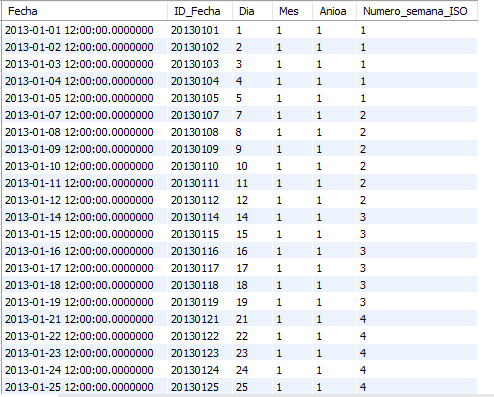

# BLOQUE 4
Bloque 4: Hecho Movimiento. Su fuente de datos es a tabla movimientos y la combinación entre las dimensiones Fecha, Producto, Proveedor, cliente, Tipo Transaccion.

Se trabaja con la tabla Producto y Cliente entregadas por el negocio en las relaciones realizadas con la tabla Hecho_movimiento

In [26]:
productos.show(5)

+---------------+-------------+--------------------+-----+-------+----------------------+-------------------+-----------------+--------+--------------+
|ID_Producto_DWH|ID_Producto_T|      NombreProducto|Marca|  Color|Necesita_refrigeracion|Dias_tiempo_entrega|PrecioRecomendado|Impuesto|PrecioUnitario|
+---------------+-------------+--------------------+-----+-------+----------------------+-------------------+-----------------+--------+--------------+
|              1|            1|USB missile launc...| null|Missing|                     0|                 14|               37|      15|            25|
|              2|            4|USB food flash dr...| null|Missing|                     0|                 14|               48|      15|            32|
|              3|            5|USB food flash dr...| null|Missing|                     0|                 14|               48|      15|            32|
|              4|            6|USB food flash dr...| null|Missing|                     0

In [27]:
clientes.show(5)

+--------------+------------+------------------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|ID_Cliente_DWH|ID_Cliente_T|            Nombre|NombreCategoria|NombreGrupoCompra|ClienteFactura|ID_CiudadEntrega|LimiteCredito|FechaAperturaCuenta|DiasPago|
+--------------+------------+------------------+---------------+-----------------+--------------+----------------+-------------+-------------------+--------+
|             0|            |           Missing|        Missing|          Missing|             0|               0|             |                   |        |
|             1|         807|     Gunnar Lohmus|     Gift Store|          Missing|           807|           35810|         3100|2013-01-01 00:00:00|       7|
|             2|         816|        Harsha Huq|     Gift Store|          Missing|           816|            8892|         2400|2013-01-01 00:00:00|       7|
|             3|         823|Francisca Laureano|    

In [25]:
sql_tpmovi ='''(SELECT *
                        FROM movimientos) AS Temp_movi'''
tpMovi = obtener_dataframe_de_bd(source_db_connection_string, sql_tpmovi, db_user, db_psswd)
tpMovi.show(20)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|                94344|       108|               10|    185.0|  19763.0|           |               |     Jan 20,2014|   -10.0|
|                96548|       162|               10|    176.0|  20221.0|           |               |     Jan 28,2014|   -10.0|
|                96560|       216|               10|    474.0|  20224.0|           |               |     Jan 28,2014|   -10.0|
|                96568|        22|               10|    901.0|  20226.0|           |               |     Jan 28,2014|   -10.0|
|                96648|        25|               10|    926.0|  20243.0|           |               |     Jan 28

Sobre los resultados del entendimiento de datos, Wide World Importers les comenta lo siguiente:

Cada fila representa una transacción o movimiento de productos en el inventario

Los días de pago no pueden ser negativos no tiene sentido para nuestro negocio. Por favor corregir multiplicando los datos negativos por -1.

Sobre la regla de negocio dada para la actividad de entendimiento de datos “La cantidad máxima de productos movidos es 50 millones por transaccion”, el negocio revisó y encontró que efectivamente gracias a los avances ya puede mover más que la cantidad de 50 millones por transacción, por lo cual ajusta la regla de negocio.

La falta de datos antes del 2014 es un error de extracción de datos. Los nuevos datos incluyen este año.

Nuestro análisis concluye que la información que se ha duplicado totalmente no es útil. Por favor no tenerlos en cuenta.

“El formato de fechas manejado es YYYY-MM-DD HH:MM:SS si tienen hora, minutos y segundos. De lo contrario el formato es YYYY-MM-DD”: En cuanto a formatos de fechas estamos de acuerdo con que los estandarizemos y el formato sea el especificado en la regla de negocio.

Existen proveedores que tienen 2 filas una con un nombre y otra con el mismo nombre mas un “Inc” o “Ltd”. Unimos estos a un solo proveedor dado que se trató de un error de digitación.

El código postal igual para todos nuestros proveedores es un error que también fue corregido.

Cantidades negativas significan salidas de productos del inventario

El negocio indica que las tablas de categoriasProveedores y TiposTransaccion fueron analizadas previamente, por su grupo de consultores.

Los datos revisados por el negocio quedan en las tablas Proveedores y movimientos y estos son los que deben utilizar en el proceso ETL. 

Por otra parte, en las tablas ProveedoresCopia y movimientosCopia quedan los datos con errores en caso de que deseen revisar/ejecutar el ejercicio que realizó de entendimiento de datos.


In [28]:
#crea tabla temporal de fechas transformadas
regex = "([0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1]))" # AAAAMMDD
cumplenFormato = tpMovi.filter(tpMovi["FechaTransaccion"].rlike(regex))
noCumplenFormato = tpMovi.filter(~tpMovi["FechaTransaccion"].rlike(regex))
print(noCumplenFormato.count(), cumplenFormato.count())

noCumplenFormato = noCumplenFormato.withColumn('FechaTransaccion', f.udf(lambda d: int(datetime.strptime(d, '%b %d,%Y').strftime('%Y%m%d')), t.IntegerType())(f.col('FechaTransaccion')))
cumplenFormato = cumplenFormato.withColumn('FechaTransaccion', f.udf(lambda d: int(datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f0').strftime('%Y%m%d')), t.IntegerType())(f.col('FechaTransaccion')))

tpMovi = noCumplenFormato.union(cumplenFormato)

tpMovi.show()



64254 203046
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|                94344|       108|               10|    185.0|  19763.0|           |               |        20140120|   -10.0|
|                96548|       162|               10|    176.0|  20221.0|           |               |        20140128|   -10.0|
|                96560|       216|               10|    474.0|  20224.0|           |               |        20140128|   -10.0|
|                96568|        22|               10|    901.0|  20226.0|           |               |        20140128|   -10.0|
|                96648|        25|               10|    926.0|  20243.0|           |              

In [29]:
# Si hay campos nulos en mov al hacer join por el left outer join no se perderan y se utiliza como comodín 
#un id=0 que debe existir en todas las dimensiones.
# Ese comodín representa el registro sin Dato en cualquiera de las dimensiones.
# Debe adicionarle a todas las tablas el registro con identificador 0.
# Se realiza el join con el resto de las domensiones incluyendo la Fecha para que la tabla quede completa.

movi = productos.alias('pr').join(tpMovi.alias('tpm'), productos.ID_Producto_T == tpMovi.ProductoID,'left')\
                .join(proveedores.alias('p'),proveedores.ID_proveedor_T == tpMovi.ProveedorID,'left')\
                .join(clientes.alias('cl'), tpMovi.ClienteID == clientes.ID_Cliente_T,'left')\
                .join(tpTransaccion.alias('tpt'), tpMovi.TipoTransaccionID == tpTransaccion.ID_Tipo_transaccion_T,'left')\
                .join(fecha.alias('fc'),fecha.ID_Fecha == tpMovi.FechaTransaccion)\
                .select([col('fc.ID_FECHA'),col('pr.ID_Producto_DWH'),col('p.ID_Proveedor_DWH'),col('cl.ID_Cliente_DWH'),
                           col('tpt.ID_tpTransaccion_DWH'),col('tpm.cantidad')])\
                  .fillna({'fc.ID_FECHA':0,'ID_Producto_DWH':0,'ID_Proveedor_DWH':0,'ID_Cliente_DWH': 0,'ID_tpTransaccion_DWH':0})


Se calcula la cantidad de registro y columnas en la tabla de movimientos entregadospor el negocio

In [30]:
rows = movi.count() 
unicos = movi.distinct().count()
cols = len(movi.columns)
print('\033[1m'+f'Dimensión de movimientos: {(rows,unicos,cols)}'+'\033[0m')

Dimensión de movimientos: (267300, 236650, 6)


Se  verifica que hay duplicados por lo que es necesario relizar la eliminación de los mismos

Se crea un nuevo dataframe que va a tener toda la información del hecho movimiento transformada y lista para continuar el proceso de cargue.

In [31]:
movimientos=movi
movimientos.join(
    movimientos.groupBy(movimientos.columns).agg((f.count("*")>1).cast("int").alias("Duplicate_indicator")),
    on=movimientos.columns,
    how="inner"
).groupBy("Duplicate_indicator").count().orderBy("count", ascending=False).show(5)


+-------------------+------+
|Duplicate_indicator| count|
+-------------------+------+
|                  0|206008|
|                  1| 61292|
+-------------------+------+



In [32]:
movi = movi.drop_duplicates()
rows = movi.count() 
unicos = movi.distinct().count()
cols = len(movi.columns)
print("\033[34m"+f'Dimensión de movimientos: {(rows,unicos,cols)}'+"\033[0,0m")

Dimensión de movimientos: (236650, 236650, 6)[0,0m


Se tienen cuatro movimientos en la tabla de Hecho que no tienen cantidades se confirmará con el negocio para realizar la eliminación de estos regsitros aunque realmente teniendo presente que se cuenta con mas de 236.000 registros no representan inconvenientes para su eliminación

In [33]:
movi.filter(movi.cantidad == 0).show()

+--------+---------------+----------------+--------------+--------------------+--------+
|ID_FECHA|ID_Producto_DWH|ID_Proveedor_DWH|ID_Cliente_DWH|ID_tpTransaccion_DWH|cantidad|
+--------+---------------+----------------+--------------+--------------------+--------+
|20150430|            201|               0|             0|                  11|     0.0|
|20140131|            127|               0|             0|                  11|     0.0|
|20150131|             34|               0|             0|                  11|     0.0|
|20140131|            218|               0|             0|                  11|     0.0|
+--------+---------------+----------------+--------------+--------------------+--------+



In [34]:
datatypes = movi.dtypes
datatypes

[('ID_FECHA', 'int'),
 ('ID_Producto_DWH', 'bigint'),
 ('ID_Proveedor_DWH', 'bigint'),
 ('ID_Cliente_DWH', 'int'),
 ('ID_tpTransaccion_DWH', 'bigint'),
 ('cantidad', 'double')]

Se hace una verificación del rango de fechas disponible en los datos con los cuales se evidencia que los movimientos incluyen datos desde el 2013.

In [35]:
#El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
movi.agg({"ID_FECHA": "min"}).show()
movi.agg({"ID_FECHA": "max"}).show()


+-------------+
|min(ID_FECHA)|
+-------------+
|     20130101|
+-------------+

+-------------+
|max(ID_FECHA)|
+-------------+
|     20160531|
+-------------+



In [ ]:
movi.show(5)

Se revisan las reglas del negocio:
1.Los nombres de los proveedores se unificaron por lo que ya no presentan dos filas
2.El código postal es único por cada proveedor
3.Los proveedores responden a las compras de productos por lo que los movimientos negativos (10) no tienen proveedor y en la transformación se completaron con 0


In [36]:
proveedores.show()

+----------------+--------------+--------------------+--------------------+------------------+---------+-------------+
|ID_Proveedor_DWH|ID_proveedor_T|              Nombre|           categoria|Contacto_Principal|Dias_Pago|Codigo_Postal|
+----------------+--------------+--------------------+--------------------+------------------+---------+-------------+
|               1|             1| A Datum Corporation| productos novedosos|        Reio Kabin|       14|        46077|
|               2|             2|       Contoso, Ltd.| productos novedosos|   Hanna Mihhailov|        7|        98253|
|               3|             3|Consolidated Mess...|servicios de mens...|      Kerstin Parn|       30|        94101|
|               4|             4|      Fabrikam, Inc.|                ropa|       Bill Lawson|       30|        40351|
|               5|             5|Graphic Design In...| productos novedosos|        Penny Buck|       14|        64847|
|               6|             6| Humongous Insu

In [37]:
proveedores.groupBy('ID_proveedor_T').pivot('Codigo_Postal').count().show()

+--------------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|ID_proveedor_T|7860|27906|37659|37770|40351|46077|56732|57543|64847|94101|95245|98253|
+--------------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|             1|null| null| null| null| null|    1| null| null| null| null| null| null|
|             2|null| null| null| null| null| null| null| null| null| null| null|    1|
|             3|null| null| null| null| null| null| null| null| null|    1| null| null|
|             4|null| null| null| null|    1| null| null| null| null| null| null| null|
|             5|null| null| null| null| null| null| null| null|    1| null| null| null|
|             6|null| null| null|    1| null| null| null| null| null| null| null| null|
|             7|null| null| null| null| null| null| null| null| null| null|    1| null|
|             8|null| null|    1| null| null| null| null| null| null| null| null| null|
|             9|null|    1| null

In [45]:
movi.groupBy('ID_Proveedor_DWH').pivot('ID_tpTransaccion_DWH').count().show()

+----------------+------+----+----+
|ID_Proveedor_DWH|     9|  10|  11|
+----------------+------+----+----+
|               0|228248|null|  44|
|               7|  null|2474|null|
|               5|  null|  42|null|
|               1|  null|  10|null|
|              10|  null|  18|null|
|              12|  null|  15|null|
|               2|  null|   3|null|
|               4|  null|5796|null|
+----------------+------+----+----+



In [39]:
movi.filter(movi.ID_tpTransaccion_DWH == "11" ).show(3)

+--------+---------------+----------------+--------------+--------------------+--------+
|ID_FECHA|ID_Producto_DWH|ID_Proveedor_DWH|ID_Cliente_DWH|ID_tpTransaccion_DWH|cantidad|
+--------+---------------+----------------+--------------+--------------------+--------+
|20140430|            196|               0|             0|                  11|    -5.0|
|20140430|             74|               0|             0|                  11|     2.0|
|20150430|            137|               0|             0|                  11|    -3.0|
+--------+---------------+----------------+--------------+--------------------+--------+
only showing top 3 rows



In [72]:
guardar_db(dest_db_connection_string, movi,'Estudiante_8_202215.Hecho_Movimiento', db_user, db_psswd)

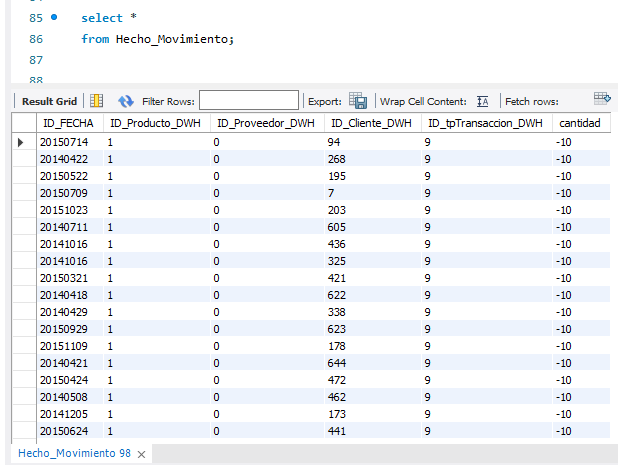

# Resultado de consultas
De acuerdo con el modelo planteado se puede validar que las tablas finales responden a los campos definidos a los tipos y a las reglas de negocio expresadas.

In [42]:
sql = '''(SELECT  * FROM Estudiante_8_202215.Hecho_Movimiento) AS Temp_hecho'''
df = obtener_dataframe_de_bd(source_db_connection_string, sql, db_user, db_psswd)
df.show()

+--------+---------------+----------------+--------------+--------------------+--------+
|ID_FECHA|ID_Producto_DWH|ID_Proveedor_DWH|ID_Cliente_DWH|ID_tpTransaccion_DWH|cantidad|
+--------+---------------+----------------+--------------+--------------------+--------+
|20150311|             49|               0|           464|                   9|  -125.0|
|20150203|            198|               0|           502|                   9|    -3.0|
|20150805|            116|               0|           502|                   9|    -8.0|
|20130411|            168|               0|           464|                   9|   -40.0|
|20160201|             90|               0|           502|                   9|  -100.0|
|20150305|            166|               0|           464|                   9|   -50.0|
|20160528|            144|               0|            47|                   9|    -5.0|
|20160420|            140|               0|           619|                   9|  -108.0|
|20130306|           

In [44]:
rows = df.count() 
unicos = df.distinct().count()
cols = len(df.columns)
print('\033[1m'+f'Dimensión de Hecho_movimientos: {(rows,unicos,cols)}'+'\033[0m')

Dimensión de Hecho_movimientos: (236650, 236650, 6)


In [57]:
df.dtypes

[('ID_FECHA', 'int'),
 ('ID_Producto_DWH', 'bigint'),
 ('ID_Proveedor_DWH', 'bigint'),
 ('ID_Cliente_DWH', 'int'),
 ('ID_tpTransaccion_DWH', 'bigint'),
 ('cantidad', 'double')]

In [48]:
df.groupBy('ID_Cliente_DWH').pivot('ID_tpTransaccion_DWH').count().show()

+--------------+---+----+----+
|ID_Cliente_DWH|  9|  10|  11|
+--------------+---+----+----+
|           471|389|null|null|
|           463|312|null|null|
|           148|348|null|null|
|           496|314|null|null|
|           243|385|null|null|
|           392|346|null|null|
|           540|329|null|null|
|           623|347|null|null|
|           516|331|null|null|
|            31|359|null|null|
|           451|419|null|null|
|           580|360|null|null|
|           137|436|null|null|
|           251|339|null|null|
|            85|333|null|null|
|            65|239|null|null|
|           458|362|null|null|
|           255|366|null|null|
|            53|290|null|null|
|           588|323|null|null|
+--------------+---+----+----+
only showing top 20 rows



In [47]:
df.select([count(when(isnan(c) | col(c).isNull() , c)).alias(c) for c in df.columns]
   ).show()

+--------+---------------+----------------+--------------+--------------------+--------+
|ID_FECHA|ID_Producto_DWH|ID_Proveedor_DWH|ID_Cliente_DWH|ID_tpTransaccion_DWH|cantidad|
+--------+---------------+----------------+--------------+--------------------+--------+
|       0|              0|               0|             0|                   0|       0|
+--------+---------------+----------------+--------------+--------------------+--------+



In [49]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()+df.where(df[c] =='').count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

In [58]:
print('detalles de hecho_movimiento: ')
columnas_vacias_ordenes = contar_vacios(df)
print('Total productos únicos: ')
print(df.select("ID_Producto_DWH").distinct().count())
df.agg({'ID_FECHA': 'Min'}).show()
df.agg({'ID_FECHA': 'Max'}).show()

detalles de hecho_movimiento: 
Total productos únicos: 
227
+-------------+
|min(ID_FECHA)|
+-------------+
|     20130101|
+-------------+

+-------------+
|max(ID_FECHA)|
+-------------+
|     20160531|
+-------------+



Se corrobora que cada fila del Hecho_movimiento corresponde a la transacción o movimiento de productos en el inventario de acuerdo con el tipo de transaccion; la tabla no presenta valores nulos o vacíos en ninguna de sus columnas, se cuentan con 236.650 registros con 6 columnas de información incluyendo identificadores que permiten complementar información de cada transacción realizada como cliente, producto, proveedor, fechas de operación ipología y cantidad del movimiento.

Las dimensiones del modelo tambien se ajustaron de acuerdo con las reglas y se encuentran disponibles para la ejecución de la consultoría de acuerdo con la analítica 1.0

In [73]:
#Se cargan los dataframes desde la base de datos
sql_proveedor = 'Estudiante_8_202215.proveedor'
sql_Cliente = 'Estudiante_8_202215.Cliente'
sql_producto = 'Estudiante_8_202215.Producto'
sql_fecha = 'Estudiante_8_202215.Fecha'
sql_TipoTransaccion = 'Estudiante_8_202215.TipoTransaccion'

prove = obtener_dataframe_de_bd(source_db_connection_string, sql_proveedor, db_user, db_psswd)
client = obtener_dataframe_de_bd(source_db_connection_string, sql_Cliente, db_user, db_psswd)
produc = obtener_dataframe_de_bd(source_db_connection_string, sql_producto, db_user, db_psswd)
fech = obtener_dataframe_de_bd(source_db_connection_string, sql_fecha, db_user, db_psswd)
TipoT = obtener_dataframe_de_bd(source_db_connection_string, sql_TipoTransaccion, db_user, db_psswd)

In [74]:
lista_dimensiones = {"Proveedores":prove, "Clientes":client, "Productos":produc, "Fechas":fech,"TipoTransaccion":TipoT}  

for k,v in lista_dimensiones.items():
    rows = v.count() 
    unicos = v.distinct().count()
    cols = len(v.columns)
    print("\033[1m"+f"TABLA: {k}"+"\033[0m")
    print('\033[1m'+f'Dimensión de {k}: {(rows,cols)}'+'\033[0m')
    print('\033[1m' +"Las dimensiones de los datos trabajados son:"+'\033[0m')
    print("Número de filas: " + str(rows)) 
    print("Número únicos: " + str(unicos))
    print("Número duplicados: "+ str(rows-unicos))
    print("Número de columnas: " + str(cols))
    print("-"*100)
    v.select([count(when(isnan(c) | col(c).isNull() , c)).alias(c) for c in v.columns]
   ).show()
    


TABLA: Proveedores
Dimensión de Proveedores: (13, 7)
Las dimensiones de los datos trabajados son:
Número de filas: 13
Número únicos: 13
Número duplicados: 0
Número de columnas: 7
----------------------------------------------------------------------------------------------------
+----------------+--------------+------+---------+------------------+---------+-------------+
|ID_Proveedor_DWH|ID_proveedor_T|Nombre|categoria|Contacto_Principal|Dias_Pago|Codigo_Postal|
+----------------+--------------+------+---------+------------------+---------+-------------+
|               0|             0|     0|        0|                 0|        0|            0|
+----------------+--------------+------+---------+------------------+---------+-------------+

TABLA: Clientes
Dimensión de Clientes: (664, 10)
Las dimensiones de los datos trabajados son:
Número de filas: 664
Número únicos: 664
Número duplicados: 0
Número de columnas: 10
-----------------------------------------------------------------------

## 4. Cierre
Completado este tutorial, ya sabe cómo realizar ETL básicos en PySpark.


## 5. Información adicional

Si quiere conocer más sobre PySpark la guía más detallada es la documentación oficial, la cual puede encontrar acá: https://spark.apache.org/docs/latest/api/python/index.html <br>
Para ir directamente a la documentación de PySpark SQL, donde está la información sobre los DataFrames, haga clic en este enlace: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html <br>

El Capítulo 2 del libro <i>Learn PySpark : Build Python-based Machine Learning and Deep Learning Models, New York: Apress. 2019</i> de Pramod Singh contiene muchos ejemplos útiles, puede encontrarlo en la biblioteca virtual de la universidad.

## 6. Preguntas frecuentes

- Si al intentar escribir un <i>dataframe</i> obtiene un error en el formato: 
    ```
    path file:<PATH>/dw/<PATH> already exists.;
    ```
    Borre la carpeta indicada en el error y vuelva a intentar.

- Si al ejecutar su código obtiene el error: 
    ```
    ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=tutorial ETL PySpark, master=local) created by __init__ at <ipython-input-4-64455da959dd>:92 

    ```
    reinicie el kernel del notebook y vuelva a intentar.